# NumPyro with Pathfinder

In this notebook we describe how to use [Blackjax](https://blackjax-devs.github.io/blackjax/)’s implementation of [`Pathfinder`](https://blackjax-devs.github.io/blackjax/autoapi/blackjax/vi/pathfinder/index.html) to do inference with a NumPyro model. According to Blackjax's documentation:

> *Pathfinder locates normal approximations to the target density along a quasi-Newton optimization path, with local covariance estimated using the inverse Hessian estimates produced by the L-BFGS optimizer. PathfinderState stores for an interation fo the L-BFGS optimizer the resulting ELBO and all factors needed to sample from the approximated target density.*

For more information about Pathfinder, please refer to the paper:

*Lu Zhang, Bob Carpenter, Andrew Gelman, and Aki Vehtari. [Pathfinder: parallel quasi-newton variational inference](https://www.jmlr.org/papers/volume23/21-0889/21-0889.pdf). Journal of Machine Learning Research, 23(306):1–49, 2022.*

This example is based on the original example notebook [NumPyro with Pathfinder](https://juanitorduz.github.io/numpyro_pathfinder/).

## Prepare Notebook

In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz blackjax

In [1]:
import arviz as az
import blackjax
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import Predictive, initialize_model

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

We generate some data from a simple linear regression model.

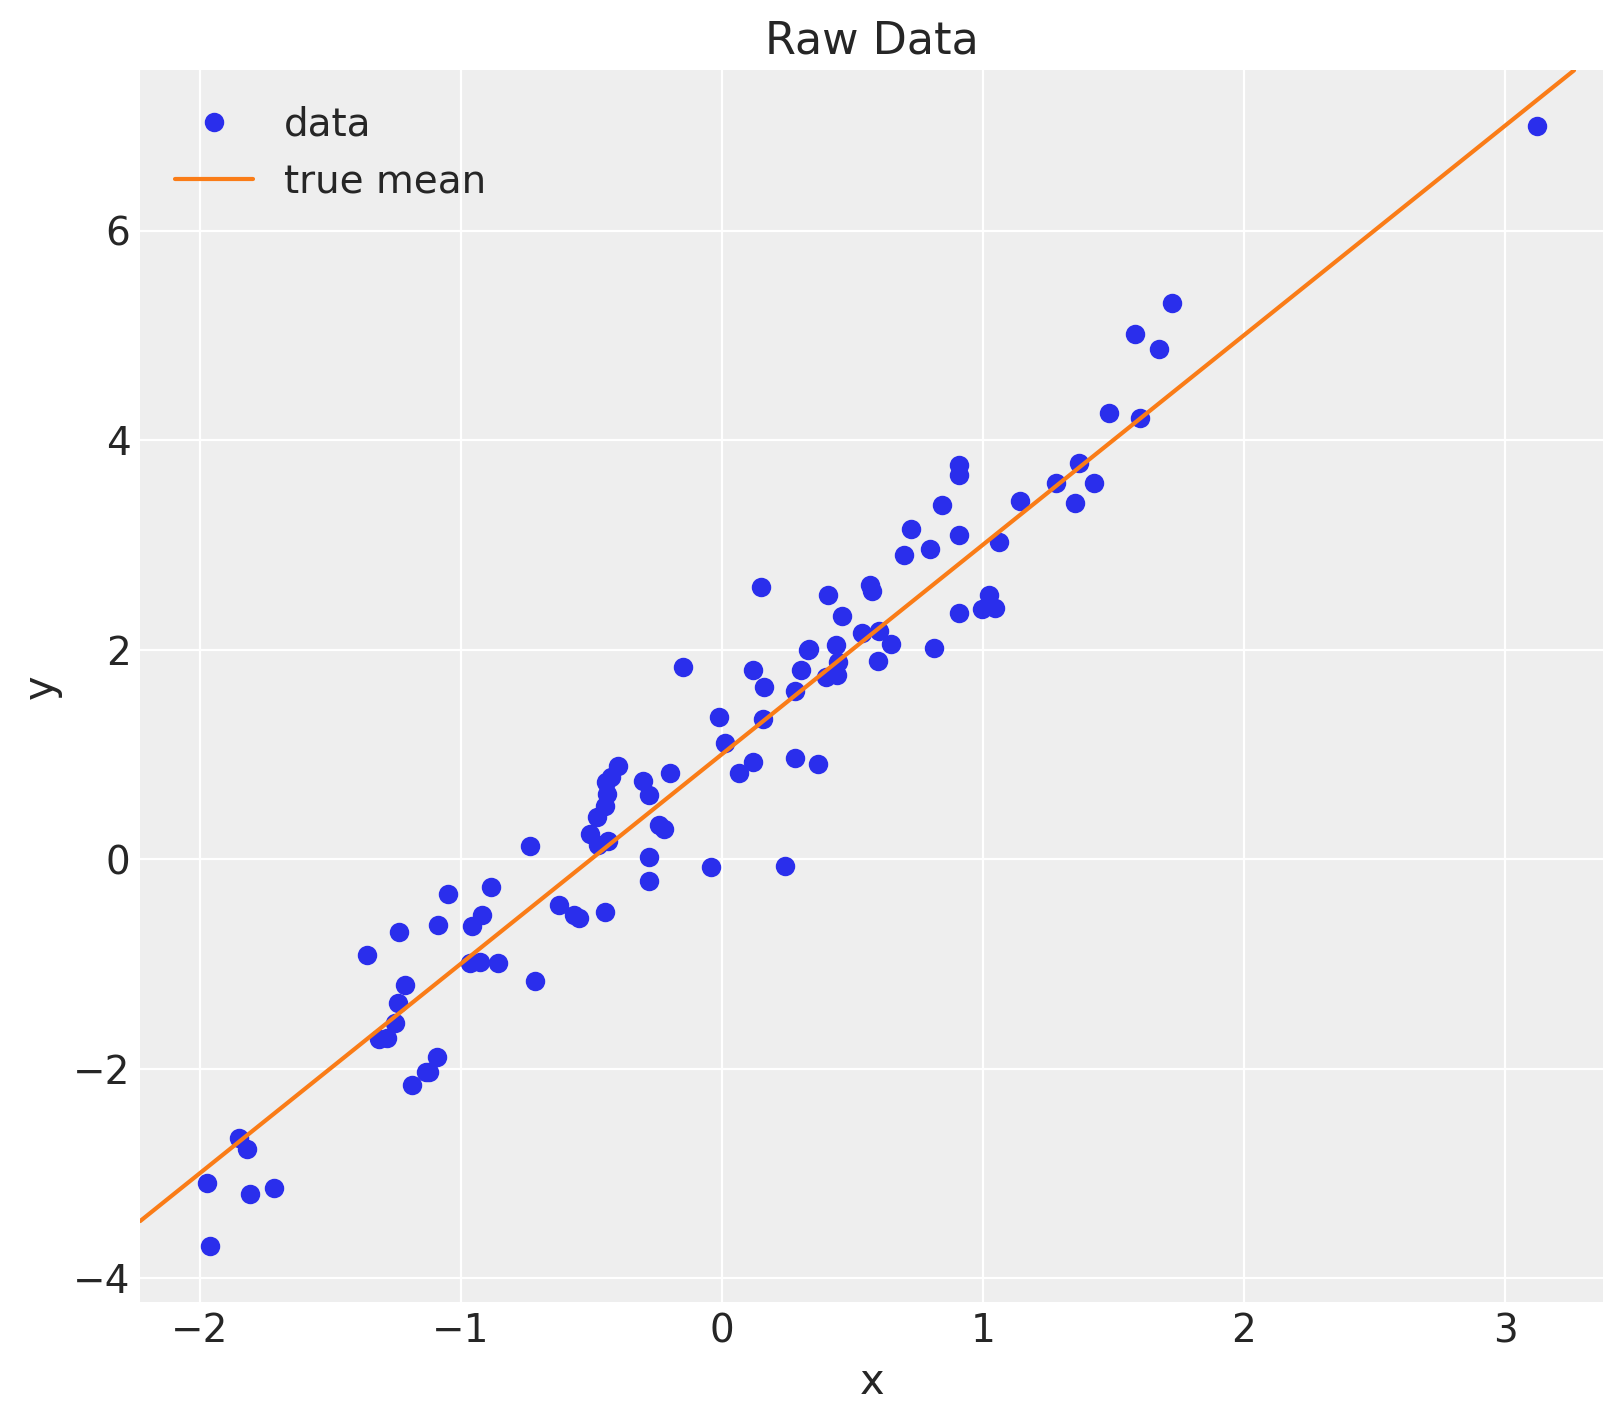

In [2]:
def generate_data(rng_key, a, b, sigma, n):
    x = random.normal(rng_key, (n,))
    rng_key, rng_subkey = random.split(rng_key)
    epsilon = sigma * random.normal(rng_subkey, (n,))
    y = a + b * x + epsilon
    return x, y


# true parameters
a = 1.0
b = 2.0
sigma = 0.5
n = 100

# generate data
rng_key, rng_subkey = random.split(rng_key)
x, y = generate_data(rng_key, a, b, sigma, n)

# plot data
fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(x, y, "o", c="C0", label="data")
ax.axline((0, a), slope=b, color="C1", label="true mean")
ax.legend(loc="upper left")
ax.set(xlabel="x", ylabel="y", title="Raw Data");

## Model Specification

We define a simple linear regression model in NumPyro.

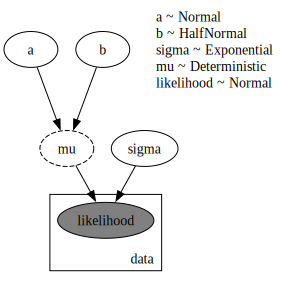

In [3]:
def model(x, y=None):
    a = numpyro.sample("a", dist.Normal(loc=0.0, scale=2.0))
    b = numpyro.sample("b", dist.HalfNormal(scale=2.0))
    sigma = numpyro.sample("sigma", dist.Exponential(rate=1.0))
    mean = numpyro.deterministic("mu", a + b * x)
    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(loc=mean, scale=sigma), obs=y)


numpyro.render_model(
    model=model,
    model_args=(x, y),
    render_distributions=True,
    render_params=True,
)

## Pathfinder Sampler

The key function is [`initialize_model`](https://num.pyro.ai/en/stable/mcmc.html#numpyro.infer.util.initialize_model) from NumPyro. This allow us to compute the log-density, which is required by Blackjax’s Pathfinder implementation. In addition, we get a way to transform the unconstrained space (where the optimization happens) to the constrained space. Let's see how to use it.

In [4]:
rng_key, rng_subkey = random.split(rng_key)
param_info, potential_fn, postprocess_fn, *_ = initialize_model(
    rng_subkey,
    model,
    model_args=(x, y),
    dynamic_args=True,  # <- this is important!
)


# get log-density from the potential function
def logdensity_fn(position):
    func = potential_fn(x, y)
    return -func(position)


# get initial position
initial_position = param_info.z

We can now use [`blackjax.vi.pathfinder.approximate`](https://blackjax-devs.github.io/blackjax/autoapi/blackjax/vi/pathfinder/index.html#blackjax.vi.pathfinder.approximate) to run the variational inference algorithm.

In [5]:
%%time

# run pathfinder
rng_key, rng_subkey = random.split(rng_key)
pathfinder_state, _ = blackjax.vi.pathfinder.approximate(
    rng_key=rng_subkey,
    logdensity_fn=logdensity_fn,
    initial_position=initial_position,
    num_samples=15_000,
    ftol=1e-4,
)

# sample from the posterior
rng_key, rng_subkey = random.split(rng_key)
posterior_samples, _ = blackjax.vi.pathfinder.sample(
    rng_key=rng_subkey,
    state=pathfinder_state,
    num_samples=5_000,
)

# convert to arviz
idata_pathfinder = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
)

CPU times: user 2.43 s, sys: 199 ms, total: 2.63 s
Wall time: 2.43 s


## Visualize Results
 
 We can visualize the results after sampling.

In [6]:
az.summary(data=idata_pathfinder, round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.043,0.051,0.951,1.139,0.001,0.001,5047.708,4780.373,NaN
b,0.730,0.028,0.679,0.785,0.000,0.000,4998.224,4873.062,NaN
sigma,-0.657,0.069,-0.785,-0.527,0.001,0.001,5056.785,5101.670,NaN


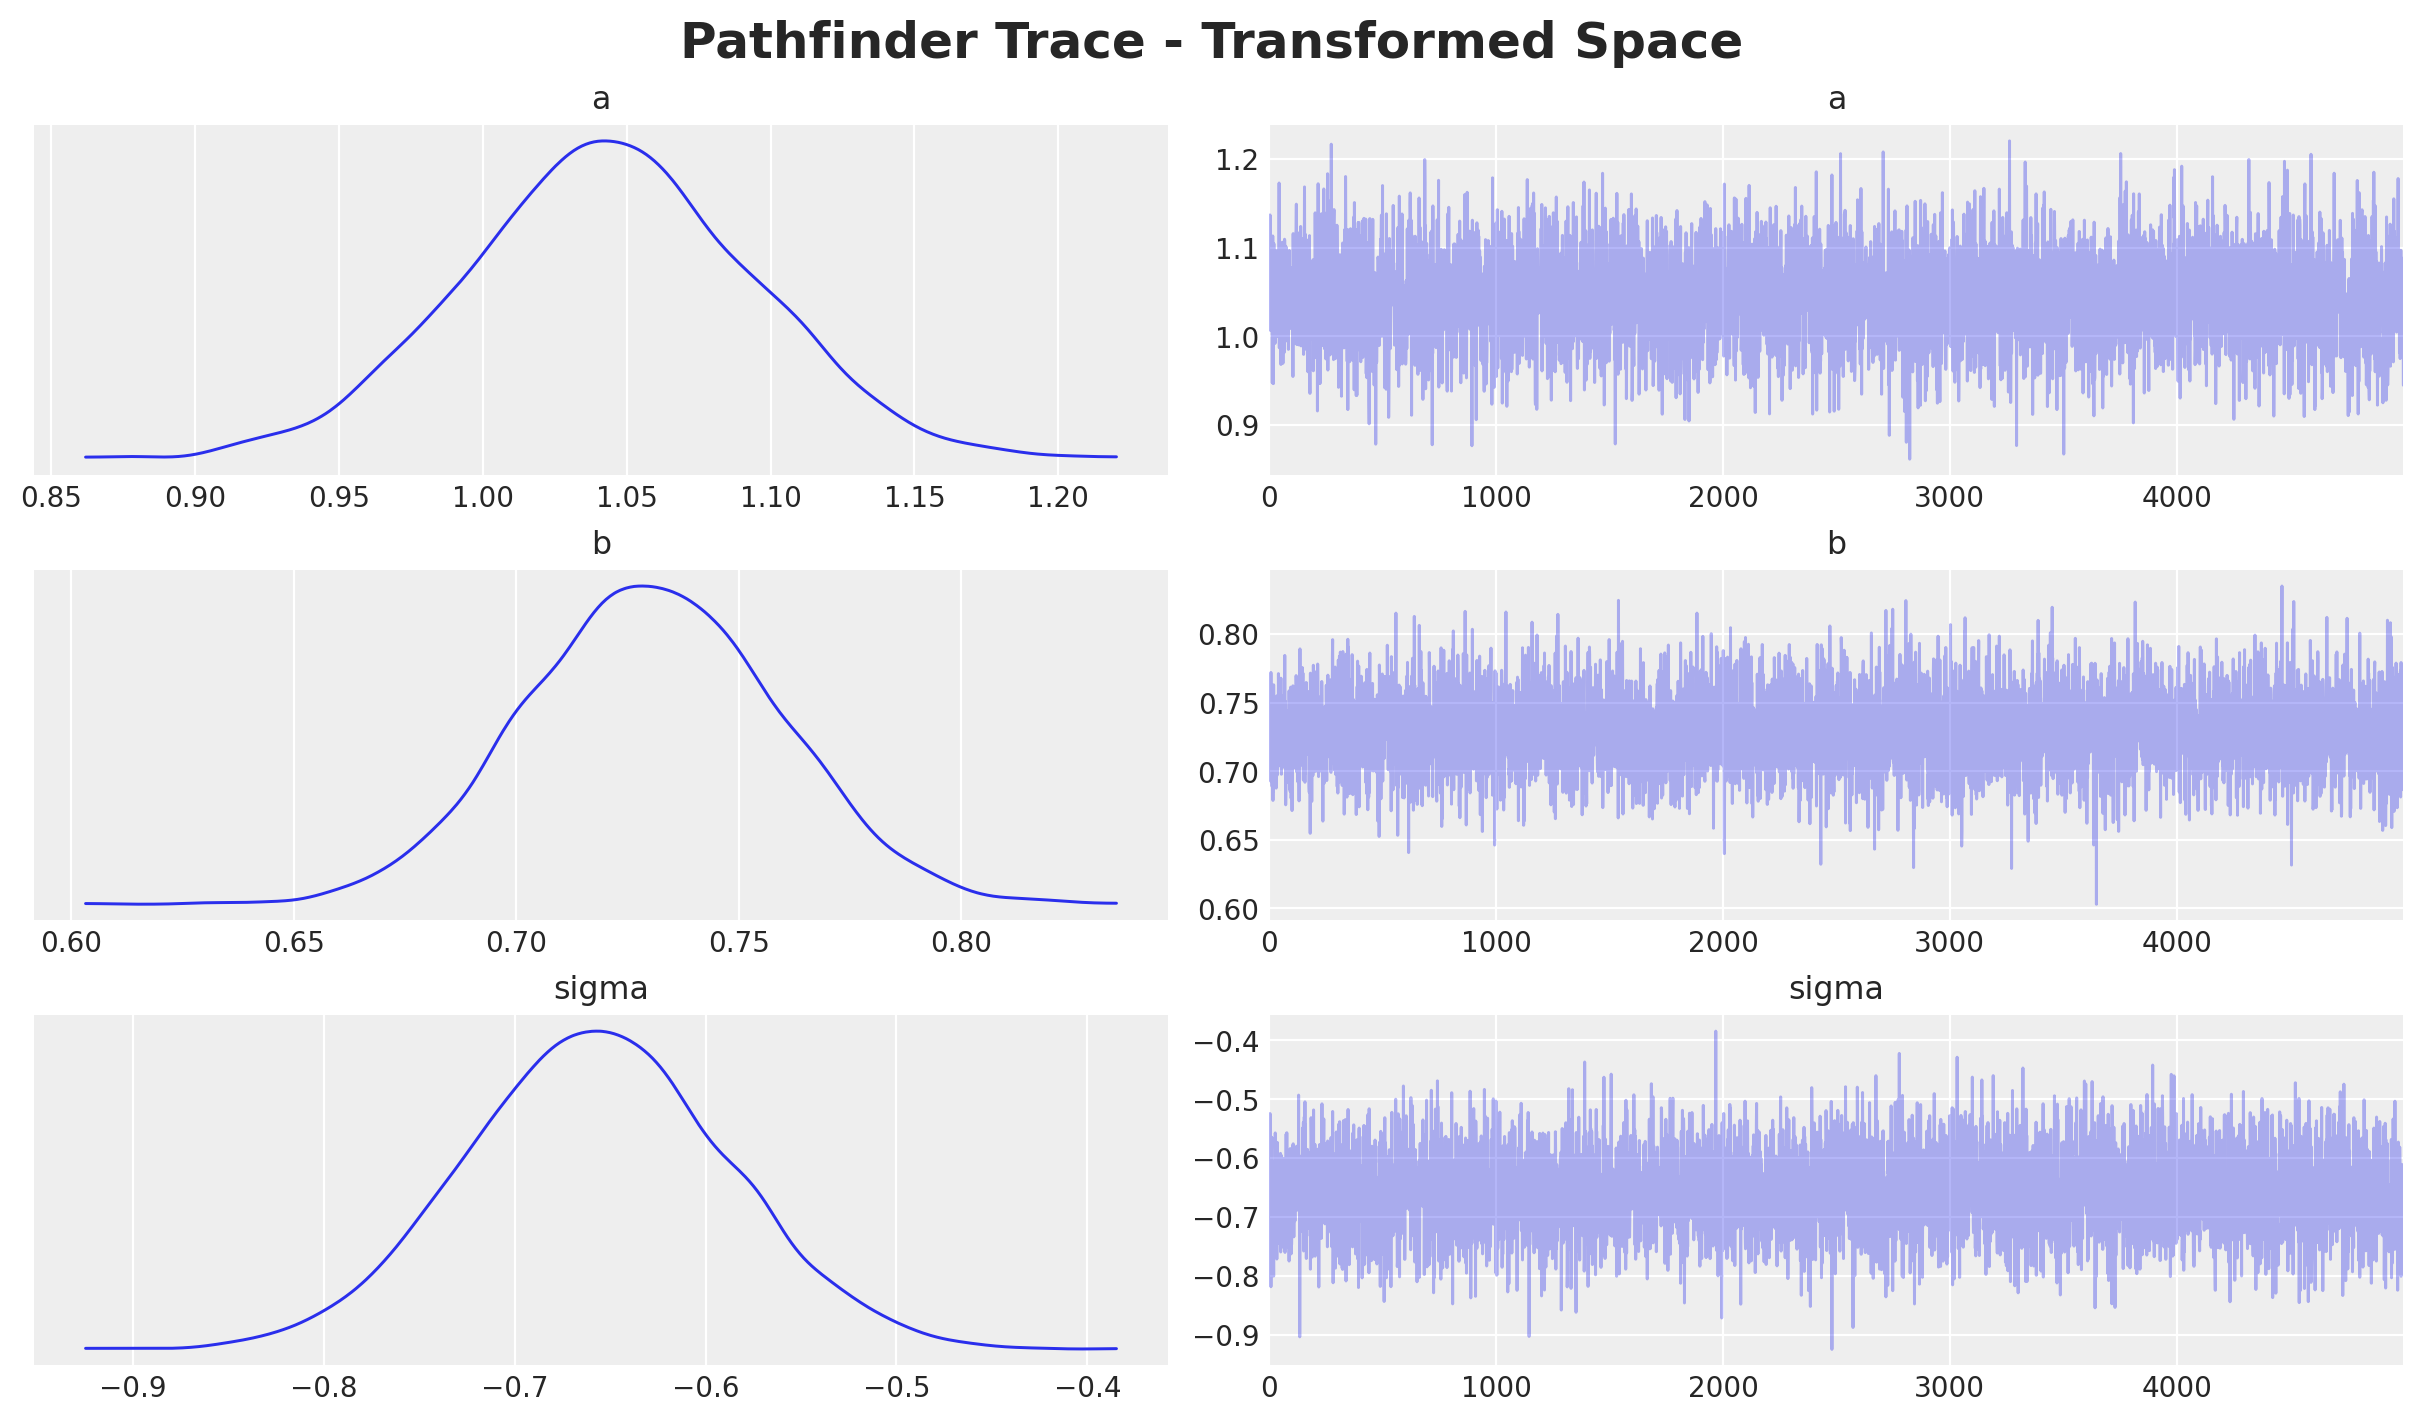

In [7]:
axes = az.plot_trace(
    data=idata_pathfinder,
    compact=True,
    figsize=(12, 7),
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(
    t="Pathfinder Trace - Transformed Space", fontsize=18, fontweight="bold"
);

Note that the value for `a` is close to the true value of `1.0`. However, the values for `b` and `sigma` do not match the true values of `2.0` `and` `0.5` respectively. The reason is that we are using prior the prior distributions `dist.HalfNormal` and `dist.Exponential` for these parameters respectively. Since these distributions are positive, the sampler transform these parameters to the unconstrained space using a bijective transformation. To compare the results in the original space, we need to apply the inverse transformation.

## Transform Samples

We can use the `postprocess_fn` function returned by `initialize_model` to transform the samples from the unconstrained space to the constrained space:

In [8]:
posterior_samples_transformed = jax.vmap(postprocess_fn(x, y))(posterior_samples)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples_transformed = Predictive(
    model=model, posterior_samples=posterior_samples_transformed
)(rng_subkey, x)

Let's see the posterior distribution in the original space.

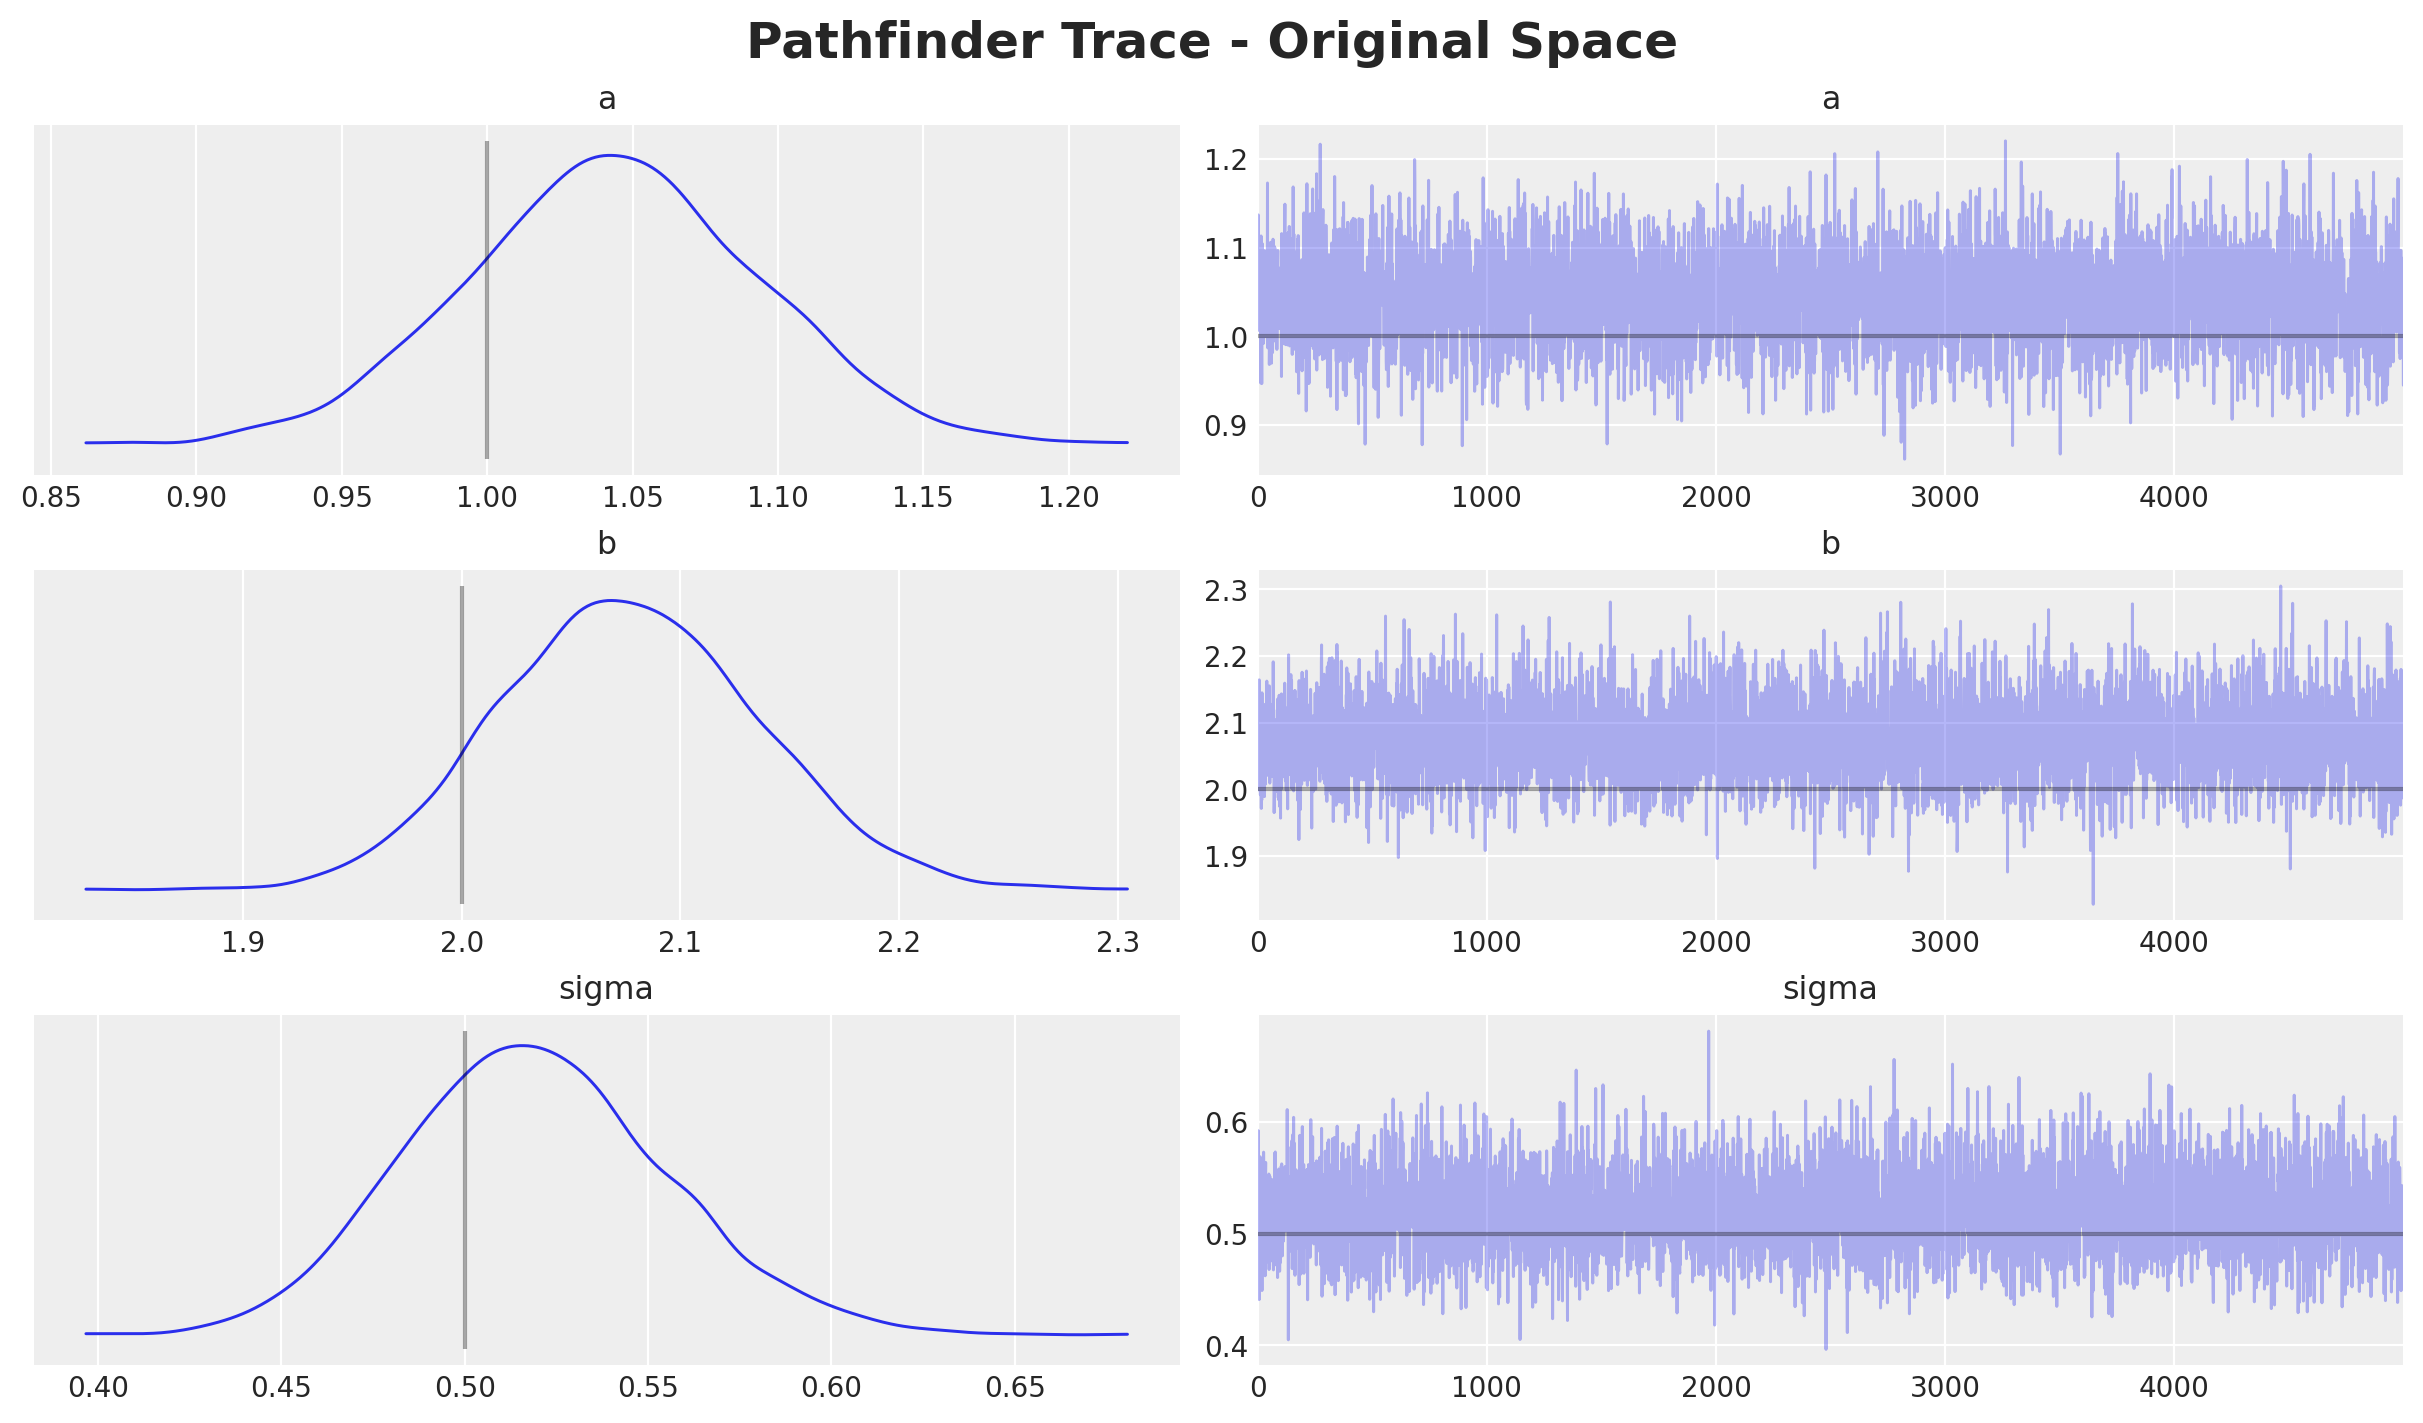

In [9]:
idata_pathfinder_transformed = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_samples_transformed.items()
    },
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples_transformed.items()
    },
)

axes = az.plot_trace(
    data=idata_pathfinder_transformed,
    var_names=["~mu"],
    compact=True,
    figsize=(12, 7),
    lines=[
        ("a", {}, a),
        ("b", {}, b),
        ("sigma", {}, sigma),
    ],
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(
    t="Pathfinder Trace - Original Space", fontsize=18, fontweight="bold"
);

Finally, we can visualize the posterior predictive distribution.

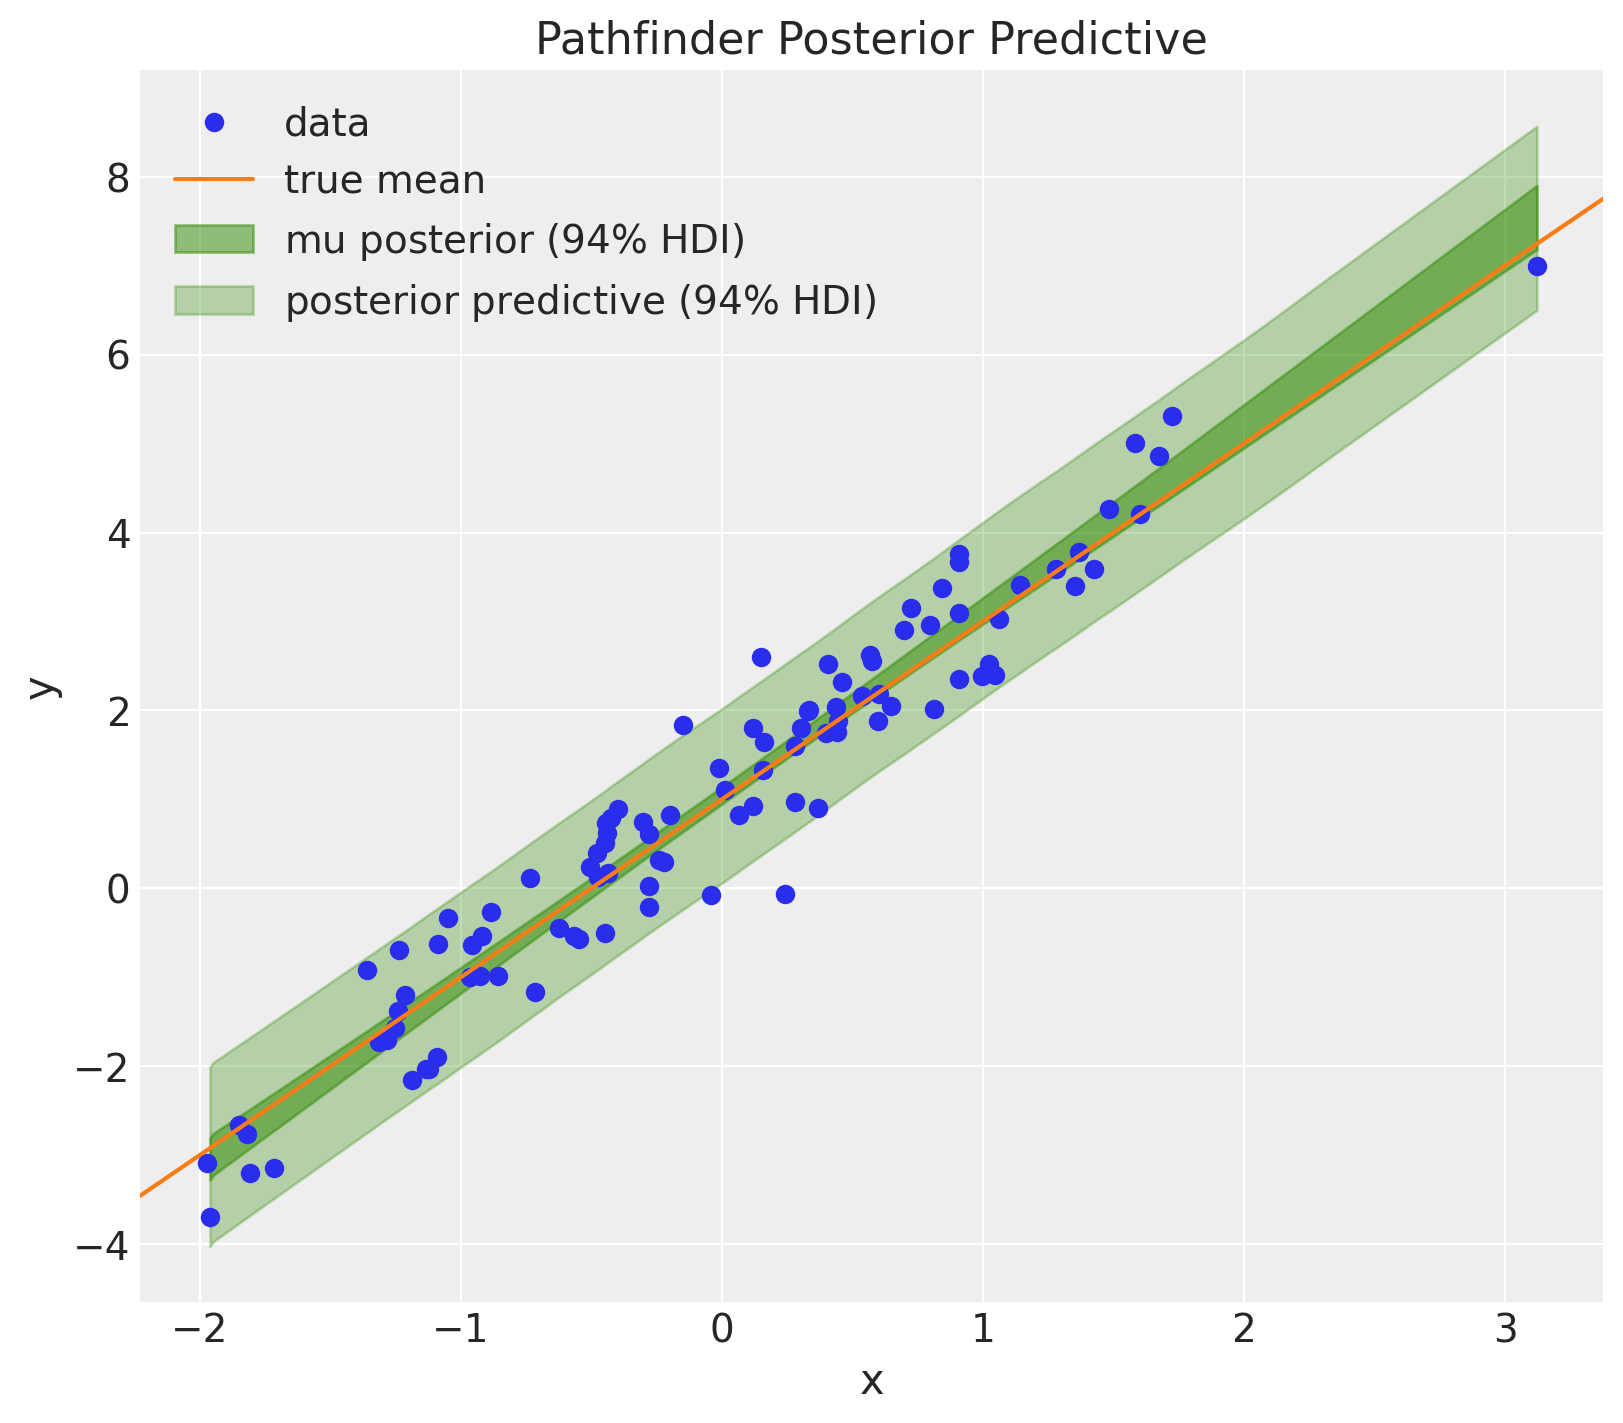

In [10]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(x, y, "o", c="C0", label="data")
ax.axline((0, a), slope=b, color="C1", label="true mean")
az.plot_hdi(
    x=x,
    y=idata_pathfinder_transformed["posterior_predictive"]["mu"],
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "mu posterior ($94\\%$ HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=x,
    y=idata_pathfinder_transformed["posterior_predictive"]["likelihood"],
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "posterior predictive ($94\\%$ HDI)"},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(xlabel="x", ylabel="y", title="Pathfinder Posterior Predictive");

The results look good!